## This notebook is used for testing MTAOS communication with the AOS components: M1M3, M2, and hexapods

Step-by-step description of what we do can be found in 
Jira test case: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T???? 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

'andes02.cp.lsst.org'

In [70]:
from lsst.ts import salobj
import asyncio
import os

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd
import yaml

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

<Figure size 432x288 with 0 Axes>

In [4]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///home/bxin/WORK/ts_ddsconfig/config/ospl-shmem.xml
summit
0


In [5]:
#index is an integter which helps avoid multple users starting same controller
script = salobj.Controller("Script", index=7)

Read historical data in 0.00 sec


In [6]:
mtcs = MTCS(script.domain)
mtcs.set_rem_loglevel(40)

Read historical data in 0.08 sec
zenithAngle DDS read queue is full (100 elements); data may be lost
temperature DDS read queue is full (100 elements); data may be lost
tangentForce DDS read queue is full (100 elements); data may be lost
tangentEncoderPositions DDS read queue is full (100 elements); data may be lost
tangentActuatorSteps DDS read queue is full (100 elements); data may be lost
Read historical data in 0.15 sec
powerStatus DDS read queue is full (100 elements); data may be lost
positionIMS DDS read queue is full (100 elements); data may be lost
position DDS read queue is full (100 elements); data may be lost
netMomentsTotal DDS read queue is full (100 elements); data may be lost
netForcesTotal DDS read queue is full (100 elements); data may be lost
ilcData DDS read queue is full (100 elements); data may be lost
forceBalance DDS read queue is full (100 elements); data may be lost
displacementSensors DDS read queue is full (100 elements); data may be lost
axialForce DDS read

In [7]:
await mtcs.start_task

[None, None, None, None, None, None, None, None, None, None]

In [6]:
#await mtcs.close() #for openSplice 6.11, the workaround was to close it then rerun the two cells above

In [8]:
mtcs.components_attr

['mtmount',
 'mtptg',
 'mtaos',
 'mtm1m3',
 'mtm2',
 'mthexapod_1',
 'mthexapod_2',
 'mtrotator',
 'mtdome',
 'mtdometrajectory']

In [9]:
camhex = mtcs.rem.mthexapod_1
m2hex = mtcs.rem.mthexapod_2
m1m3 = mtcs.rem.mtm1m3
m2 = mtcs.rem.mtm2
aos = mtcs.rem.mtaos
mount = mtcs.rem.mtmount

In [38]:
rot = mtcs.rem.mtrotator

In [10]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
aos.evt_logMessage.callback = printLogMessage
await aos.cmd_setLogLevel.set_start(level=10, timeout=5)

In [11]:
await aos.evt_heartbeat.next(flush=True, timeout=5)

In [19]:
await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply="Default")

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [20]:
await salobj.set_summary_state(aos, salobj.State.ENABLED) #, settingsToApply='default') #leave this out!!
#two levels of defaults: csc defaults, config repo; right now csc defaults, they will move to config repo; 
#but to load defaults from config repo, we do not need to supply settingsToApply

20: Execute configure().


[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [85]:
summit = 1 #use this for summit testing
#summit = 0 #use this for NCSA

In [86]:
from lsst_efd_client import EfdClient

if summit:
    client = EfdClient('summit_efd')
else:
    client = EfdClient('ncsa_teststand_efd')
csc_index = 1

#### Check summary state of each CSC

In [77]:
await checkAOSSummaryStates(aos, m1m3, m2, camhex, m2hex)

starting with: MTAOS state State.ENABLED 2021-05-14 16:16:23.853466880
starting with: M1M3 state State.ENABLED 2021-05-14 17:56:13.438517760
          detailed state DetailedState.ACTIVE 2021-05-14 17:56:13.438554880
staring with: m2 state State.ENABLED 2021-05-14 15:54:02.175356160
staring with: cam hex state State.ENABLED 2021-05-14 16:18:41.141967104
          cam hex state EnabledSubstate.STATIONARY 2021-05-14 16:45:11.453358080
staring with: M2 hex state State.ENABLED 2021-05-14 16:18:53.143941120
          hex state EnabledSubstate.STATIONARY 2021-05-14 16:46:06.419370240


### Get M1M3 Ready: raise mirorr, turn on FB, clear forces

In [57]:
await m1m3.evt_heartbeat.next(flush=True, timeout=5)

In [59]:
print('Re-enabling M1M3')
#await salobj.set_summary_state(m1m3, salobj.State.STANDBY) 
await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

Re-enabling M1M3


[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [67]:
await readyM1M3(m1m3)

m1m3 inclinometer Angle =  90.00399780273438
m1m3 state DetailedState.RAISING 2021-05-14 17:07:51.070529280


TimeoutError: 

In [ ]:
#SELECT "errorCode", "errorReport" FROM "efd"."autogen"."lsst.sal.MTM1M3.logevent_errorCode" WHERE time > :dashboardTime: AND time < :upperDashboardTime:

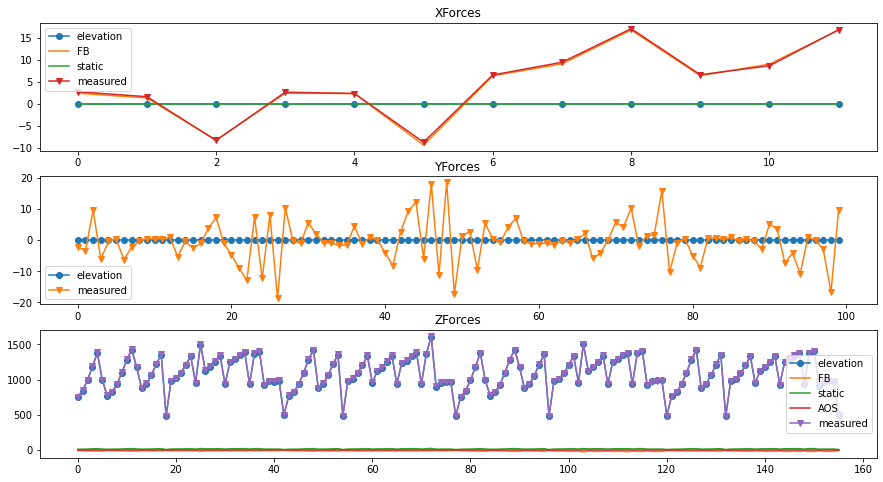

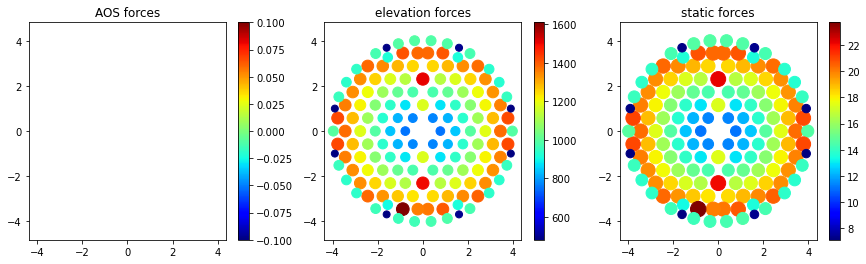

In [62]:
#%matplotlib inline
await plotM1M3Forces(m1m3)

### Get M2 Ready: turn on FB, clear forces

In [24]:
await m2.evt_heartbeat.next(flush=True, timeout=5)

In [25]:
sstate = await m2.evt_summaryState.aget(timeout=5)
print('staring with: m2 state',salobj.State(sstate.summaryState), pd.to_datetime(sstate.private_sndStamp, unit='s'))

staring with: m2 state State.ENABLED 2021-05-14 15:54:02.175356160


In [18]:
await salobj.set_summary_state(m2, salobj.State.ENABLED) 
#await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [ ]:
await m2.cmd_enterControl.set_start(timeout = 5.)

In [26]:
await readyM2(m2)

m2 inclinometer angle =  0.42699951171874556
Status of the M2 force balance system True
clear any M2 activeopticForces (or any other hunman-applied forces)


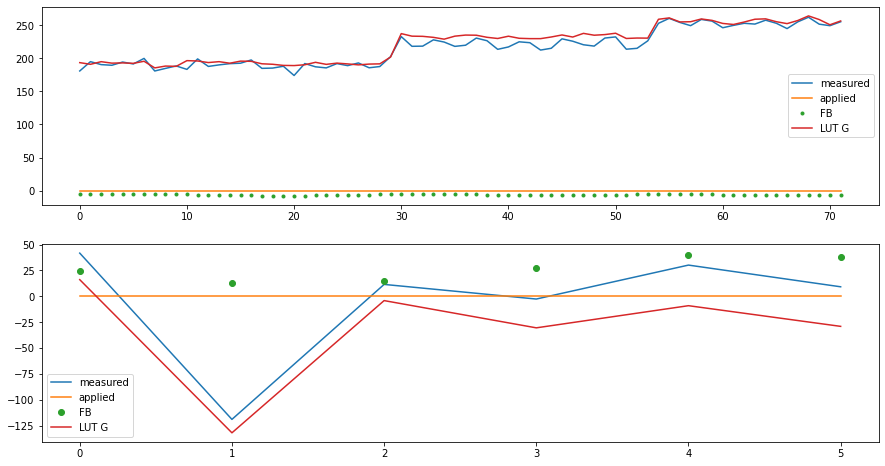

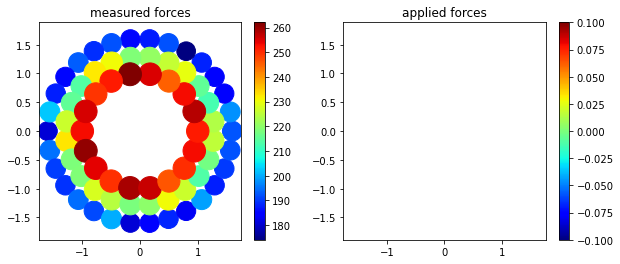

In [27]:
await plotM2Forces(m2)

### Get cam hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [28]:
await camhex.evt_heartbeat.next(flush=True, timeout=5)

In [36]:
await salobj.set_summary_state(mount, salobj.State.ENABLED) #, settingsToApply = 'Default') 

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [39]:
await salobj.set_summary_state(rot, salobj.State.ENABLED)

[<State.OFFLINE: 4>,
 <State.STANDBY: 5>,
 <State.DISABLED: 1>,
 <State.ENABLED: 2>]

In [42]:
await mount.cmd_moveToTarget.set_start(elevation=75, azimuth=0)

In [47]:
await rot.cmd_move.set_start(position=0)

In [48]:
await readyHexaForAOS(camhex)

settingsVersion =  default.yaml:v0.7.2-0-g4375e27 2021-05-14 16:18:40.879104256
pivot at (0, 0, 500000) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg
compsensation mode enabled? True 2021-05-14 16:20:54.575137024
hexapod already at LUT position
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-05-14 16:41:26.834880768
Compensated position
     -0.82    -311.15     267.00      -0.008571   0.000000   0.000000    2021-05-14 16:45:10.647736064
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  75.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -0.8197689278882421 -311.1522845009765 266.9954574997853 -0.008570978028279296 0.0 0.0


In [46]:
await camhex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

In [19]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.DISABLED: 1>, <State.STANDBY: 5>]

In [ ]:
await camhex.cmd_exitControl.set_start(timeout=10.)

In [22]:
await salobj.set_summary_state(camhex, salobj.State.ENABLED, settingsToApply="default")

[<State.OFFLINE: 4>,
 <State.STANDBY: 5>,
 <State.DISABLED: 1>,
 <State.ENABLED: 2>]

In [49]:
state = await camhex.evt_summaryState.aget(timeout=5)
print('staring with: cam hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))
dstate = await camhex.evt_controllerState.aget(timeout=5)
print('          cam hex state', MTHexapod.EnabledSubstate(dstate.enabledSubstate), 
  pd.to_datetime(dstate.private_sndStamp, unit='s'))

staring with: cam hex state State.ENABLED 2021-05-14 16:18:41.141967104
          cam hex state EnabledSubstate.STATIONARY 2021-05-14 16:45:11.453358080


In [ ]:
mount_angle = await mount.tel_elevation.next(flush=False, timeout=10.)
print("mount elevation angle", mount_angle.actualPosition)
elev = mount_angle.actualPosition

### Get M2 hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [50]:
await m2hex.evt_heartbeat.next(flush=True, timeout=5)

In [48]:
await m2hex.cmd_setCompensationMode.set_start(enable=0, timeout=10)

In [51]:
await m2hex.cmd_move.set_start(x=0,y=0,z=100, u=0,v=0,w=0,sync=True)

In [52]:
await printHexaPosition(m2hex)
await printHexaUncompensatedAndCompensated(m2hex)

Current Hexapod position
     -0.02       0.03      99.99   0.000000  -0.000000  -0.000000
Uncompensated position
      0.00       0.00     100.00      0.000000   0.000000   0.000000    2021-05-14 16:45:57.681982720
Compensated position
      0.00       0.00     100.00       0.000000   0.000000   0.000000    2021-05-14 16:45:57.682169088


In [53]:
await readyHexaForAOS(m2hex)

settingsVersion =  default.yaml:v0.7.2-0-g4375e27 2021-05-14 16:18:52.874925824
pivot at (0, 0, 500000) microns 
maxXY =  10500.0 microns, maxZ=  8900.0  microns
maxUV =  0.175 deg, maxW=  0.05  deg
compsensation mode enabled? True 2021-05-14 16:46:05.405184768
hexa in position? False 2021-05-14 16:46:05.510349312
hexa in position? True 2021-05-14 16:46:06.420151296
Current Hexapod position
     -2.74    -270.32     288.51  -0.003236  -0.000000  -0.000000
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-05-14 16:46:06.117644544
Compensated position
     -2.74    -270.37     288.52      -0.003236   0.000000   0.000000    2021-05-14 16:46:06.117844480
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  75.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -2.7378341010400375 -270.36866857539064 288.51589440595694 -0.003236147000060546 0.0 0.0


In [23]:
await salobj.set_summary_state(m2hex, salobj.State.ENABLED, settingsToApply="default")

[<State.OFFLINE: 4>,
 <State.STANDBY: 5>,
 <State.DISABLED: 1>,
 <State.ENABLED: 2>]

### Step 1: add aberrations via OFC

In [54]:
zernikes = np.zeros(19)
zerIdx = np.arange(4, 23)
zernikes[7-4] = 1 #add 1um of z7
print(zerIdx)
print(zernikes)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [97]:
config = {"xref": "x0"}  # add config as needed
config_yaml = yaml.safe_dump(config)

In [98]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)
#await aos.cmd_issueCorrection.set_start() #in the future, we want to issue corrections manually

20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


DOF event time =  2021-05-14 18:24:18.683407360
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


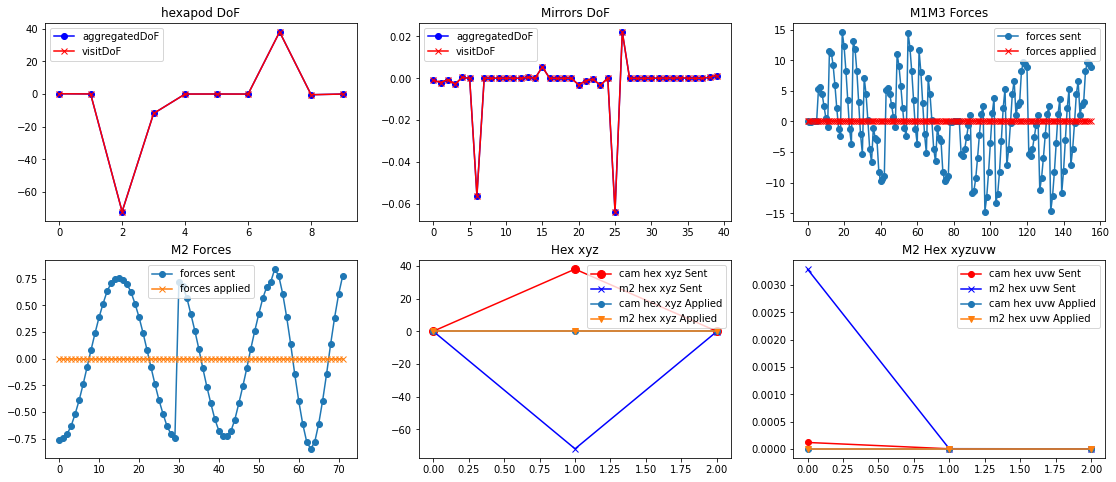

In [99]:
ofc_dict =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [100]:
await aos.cmd_issueCorrection.set_start() 

20: Execute do_issueCorrection().
20: Issue the M2 correction successfully.


DOF event time =  2021-05-14 18:24:18.683407360
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


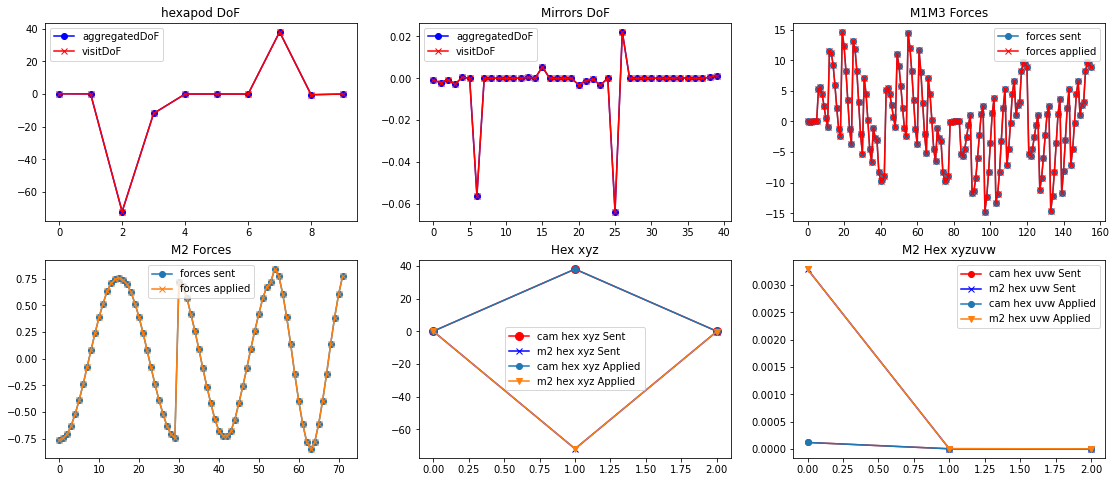

In [101]:
ofc_dict =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [75]:
# Disable all corrections except camera hexapod
new_comp_dof_idx = dict(
    m2HexPos=np.zeros(5, dtype=bool).tolist(),
    camHexPos=np.ones(5, dtype=bool).tolist(),
    M1M3Bend=np.zeros(20, dtype=bool).tolist(),
    M2Bend=np.zeros(20, dtype=bool).tolist(),
)
config = {"comp_dof_idx":new_comp_dof_idx}
config_yaml = yaml.safe_dump(config)
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml) 

40: Error setting value in ofc_data. Restoring original values.


AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=219186663, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: Size of input vector (4) different than expected (5).')

40: Callback <bound method MTAOS.do_addAberration of <lsst.ts.MTAOS.mtaos.MTAOS object at 0x7f57eaeeee50>> failed with data=private_revCode: 8adfd49b, private_sndStamp: 1621014608.1501071, private_rcvStamp: 1621014608.1506572, private_seqNum: 219186663, private_identity: Script:7, private_origin: 7807, private_host: 0, wf: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], config: comp_dof_idx:
  M1M3Bend:
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  M2Bend:
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  camHexPos:
  - true
  - true
  - true
  - true
  - true
  m2HexPos:
  - false
  - false
  - false
  - false
  - false



In [76]:
config_yaml

'comp_dof_idx:\n  M1M3Bend:\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  M2Bend:\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  camHexPos:\n  - true\n  - true\n  - true\n  - true\n  - true\n  m2HexPos:\n  - false\n  - false\n  - false\n  - false\n  - false\n'

#### Look at telemetry to verify the changes in the DOFs

In [104]:
#end = Time(datetime.now(), scale='tai')
end = Time('2021-05-14T18:25:30', scale = 'tai')
start = end - timedelta(seconds=100)

dfm = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start, end, csc_index)
dfm1m3 = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedActiveOpticForces', '*', start, end, csc_index)
dfm2 = await client.select_time_series('lsst.sal.MTM2.axialForce', '*', start, end, csc_index)
dfh = await client.select_time_series('lsst.sal.MTHexapod.logevent_uncompensatedPosition', '*', start, end, csc_index)

idx1=dfh.MTHexapodID==1
dfh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
dfh2 = dfh[idx2]

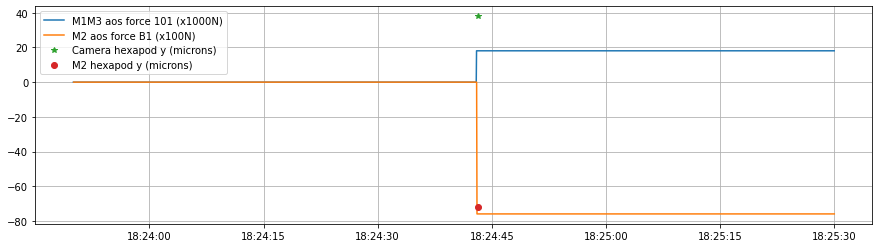

In [105]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
#plt.plot(dfm.actualPosition, '--', label='mount elevation')
plt.plot(dfm1m3.zForces0*1e3, label='M1M3 aos force 101 (x1000N)')
plt.plot(dfm2.applied0*1e2, label='M2 aos force B1 (x100N)')
plt.plot(dfh1.y, '*', label='Camera hexapod y (microns)')
plt.plot(dfh2.y, 'o', label='M2 hexapod y (microns)')
plt.grid()
plt.legend()

### Step 2: add same aberrations twice. Are the aggregateDOF accumulating?

In [106]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)

20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


In [107]:
await aos.cmd_issueCorrection.set_start() 

20: Execute do_issueCorrection().
20: Issue the M2 correction successfully.


DOF event time =  2021-05-14 18:27:41.824512768
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


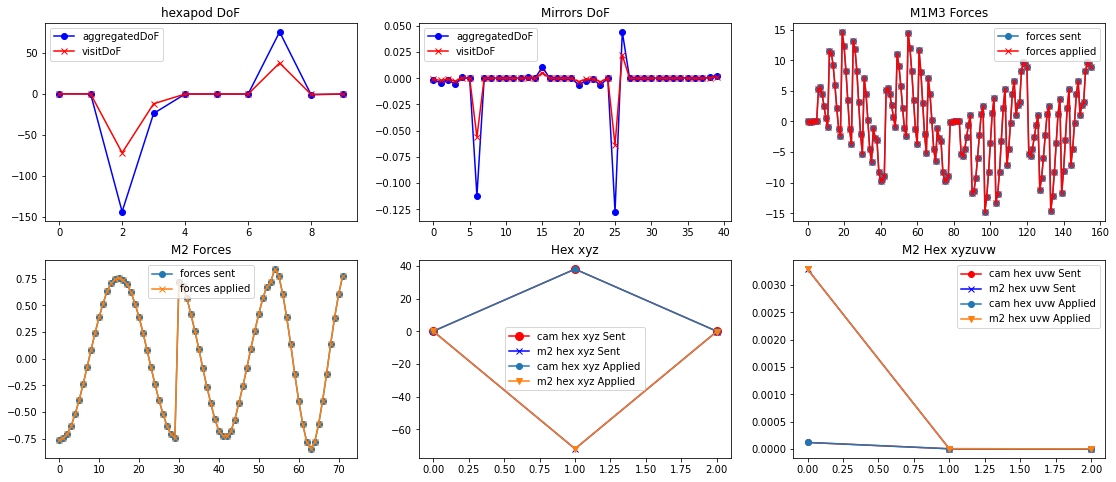

In [108]:
ofc_dict2 = await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot=True)

This depends on the control strategy we are using. For x00, do not expect 2 or 1.

In [109]:
ofc_dict2['camhexC'][:5]/ofc_dict['camhexC'][:5]

array([1., 1., 1., 1., 1.])

In [110]:
ofc_dict2['m2hexC'][:5]/ofc_dict['m2hexC'][:5]

array([1., 1., 1., 1., 1.])

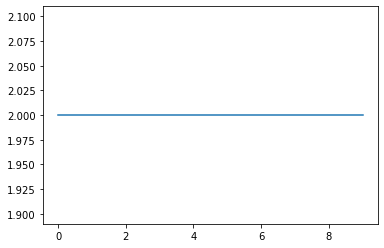

In [111]:
plt.plot(ofc_dict2['aggregated_dof'][:10]/ofc_dict['aggregated_dof'][:10])

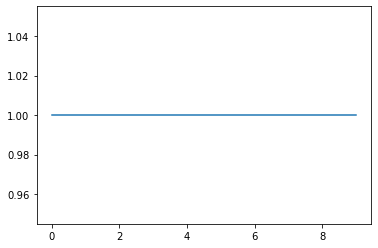

In [112]:
plt.plot(ofc_dict2['visit_dof'][:10]/ofc_dict['visit_dof'][:10])

### Step 3: Reset the corrections

In [113]:
await aos.cmd_resetCorrection.set_start()

20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


In [114]:
##the following should be done by cmd_resetCorrection, but right now this is not the case
await aos.cmd_issueCorrection.set_start() 
#issue the resetted correction, which should be equivalent to the below
#await m1m3.cmd_applyActiveOpticForces.set_start(zForces=[0]*156)
#await m2.cmd_resetForceOffsets.set_start()
#await camhex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)
#await m2hex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

20: Execute do_issueCorrection().
20: Issue the M2 correction successfully.


DOF event time =  2021-05-14 18:32:56.409236480
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


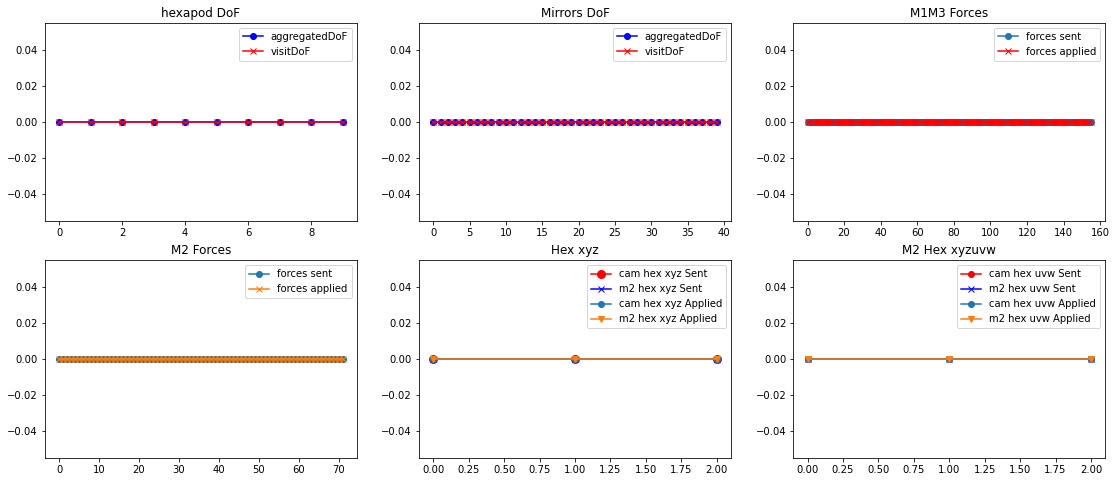

In [115]:
ofc_dict3 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

### Step 4: Double the aberration, do the corrections double? yes

In [116]:
zernikes[7-4] = 2 # z7 = 2um

In [117]:
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


In [118]:
await aos.cmd_issueCorrection.set_start() 

20: Execute do_issueCorrection().
20: Issue the M2 correction successfully.


DOF event time =  2021-05-14 18:33:27.497613568
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


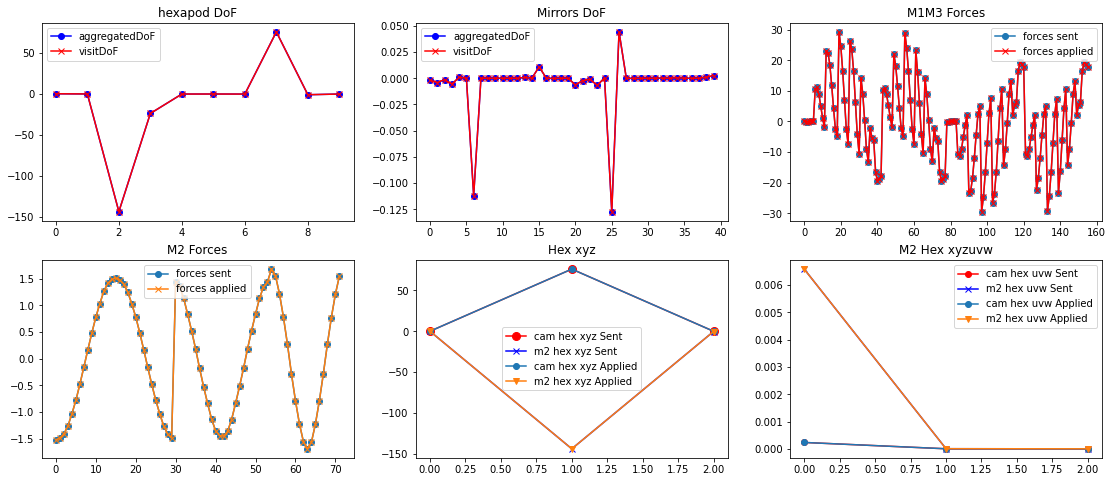

In [119]:
ofc_dict4 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [120]:
ofc_dict4['camhexC'][:5]/ofc_dict['camhexC'][:5]

array([2., 2., 2., 2., 2.])

In [121]:
ofc_dict4['m2hexC'][:5]/ofc_dict['m2hexC'][:5]

array([2., 2., 2., 2., 2.])

### Step 5: Observe the corrections being rejected

In [121]:
#await lowerM1M3(m1m3)

m1m3 state DetailedState.LOWERING 2021-05-04 17:34:45.484768256
m1m3 state DetailedState.PARKED 2021-05-04 17:36:37.899777536


In [122]:
await salobj.set_summary_state(remote=camhex, state=salobj.State.DISABLED) 

[<State.ENABLED: 2>, <State.DISABLED: 1>]

In [123]:
#Expect this command to be rejected, because M1M3 is parked
zernikes[7-4] = 1
await aos.cmd_addAberration.set_start(wf = zernikes) #config=??

20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


DOF event time =  2021-05-14 18:36:23.380032768
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


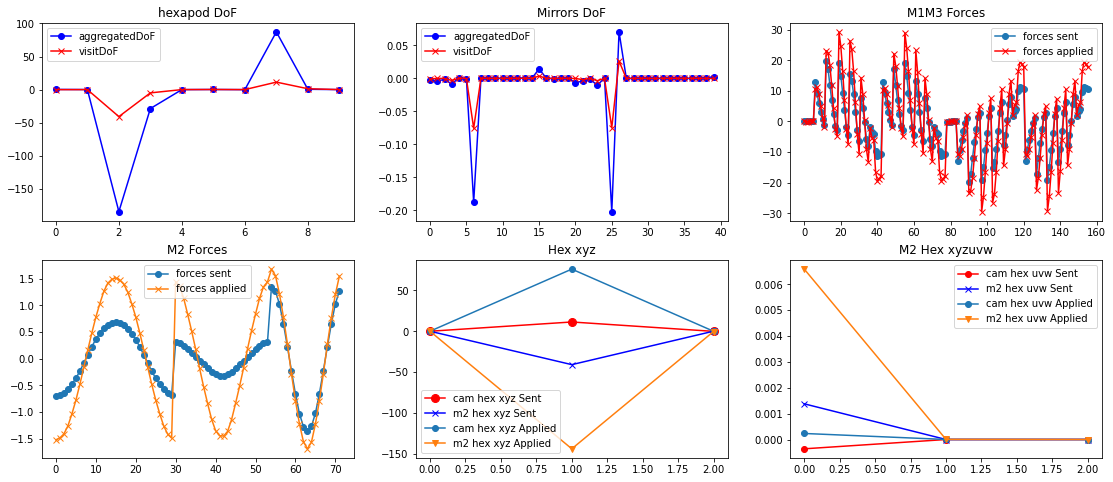

In [124]:
ofc_dict5 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [125]:
await aos.cmd_rejectCorrection.set_start()

20: Execute do_rejectCorrection().
20: Execute pubEvent_rejectedDegreeOfFreedom().


DOF event time =  2021-05-14 18:36:23.380032768
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


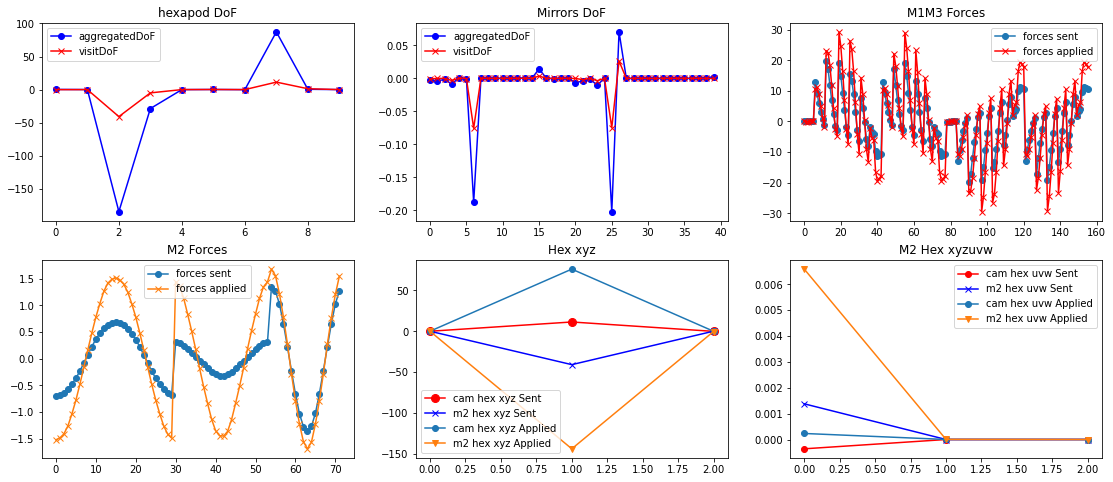

In [126]:
ofc_dict5 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [127]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)

20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


In [128]:
await aos.cmd_issueCorrection.set_start()

20: Execute do_issueCorrection().
40: Camera hexapod correction command failed.
20: Execute pubEvent_rejectedCameraHexapodCorrection().
20: Issue the M2 correction successfully.
20: Execute pubEvent_rejectedDegreeOfFreedom().
30: Undoing m2hex correction.
30: Undoing m2 correction.
20: Issue the M2 correction successfully.
30: Undoing m1m3 correction.
40: Callback <bound method MTAOS.do_issueCorrection of <lsst.ts.MTAOS.mtaos.MTAOS object at 0x7f57eaeeee50>> failed with data=private_revCode: 29ef8f2b, private_sndStamp: 1621017797.0337422, private_rcvStamp: 1621017797.0343883, private_seqNum: 763213328, private_identity: Script:7, private_origin: 7807, private_host: 0


AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=763213328, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result="Failed: Failed to apply correction to: ['camhex']. ")

DOF event time =  2021-05-14 18:42:20.743750912
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


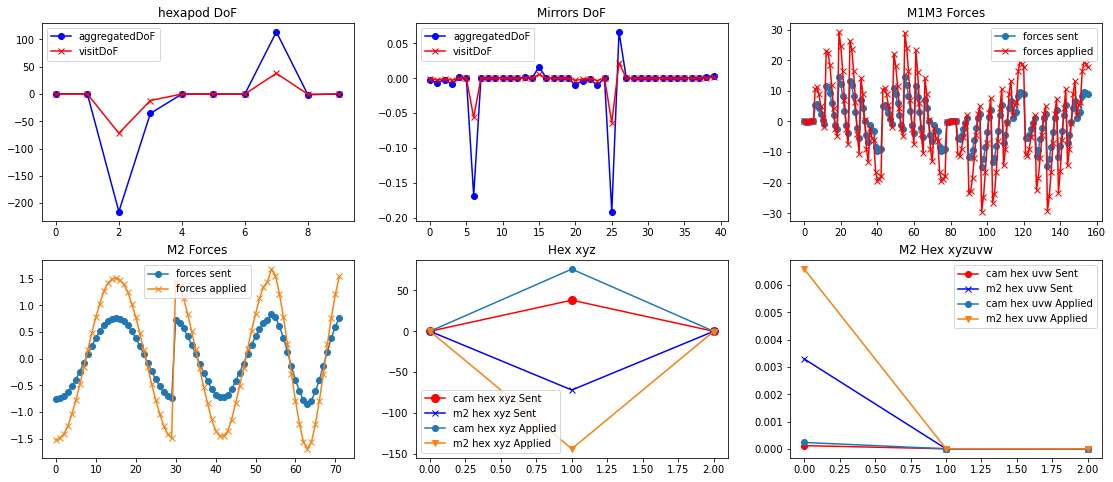

In [129]:
ofc_dict5 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [130]:
await aos.cmd_rejectCorrection.set_start()

20: Execute do_rejectCorrection().
20: Execute pubEvent_rejectedDegreeOfFreedom().


DOF event time =  2021-05-14 18:42:20.743750912
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


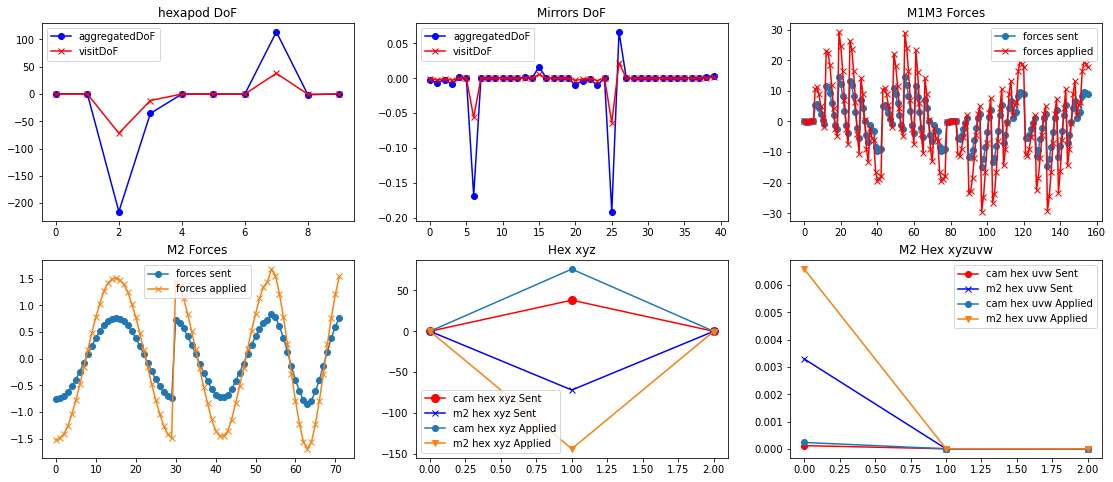

In [131]:
ofc_dict6 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

#### the addAberration command is supposed to have undone corrections to M2, camhex, and m2hex. Let's check that

In [133]:
print(np.array(ofc_dict5['m1m3C']) - np.array(ofc_dict4['m1m3C']))
#print(ofc_dict5['m2C'] - ofc_dict4['m2C'])
#print(ofc_dict5['camhexC'] - ofc_dict4['camhexC'])
#print(ofc_dict5['m2hexC'] - ofc_dict4['m2hexC'])

[-1.80604644e-02  2.28653811e-02  2.78958473e-02  2.29876721e-03
 -2.71762908e-02 -4.98860739e-02 -5.30540371e+00 -5.58094358e+00
 -4.46250153e+00 -2.58714223e+00 -6.42585456e-01  9.55541790e-01
 -1.15409298e+01 -1.12497053e+01 -9.23964787e+00 -5.91740513e+00
 -2.22455430e+00  1.15694356e+00  2.40849495e+00 -1.46352663e+01
 -1.22675877e+01 -8.31374168e+00 -3.52358699e+00  1.24463344e+00
  3.70137501e+00 -1.31810207e+01 -1.17674646e+01 -8.16786194e+00
 -3.15621805e+00  2.12836409e+00  5.26547956e+00 -7.16293859e+00
 -4.52300692e+00 -2.51386732e-01  4.50111151e+00  6.59903812e+00
  1.07200503e+00  2.62840962e+00  3.10125971e+00  8.20224190e+00
  9.76642513e+00  9.37503052e+00  8.88022041e+00 -5.19863033e+00
 -5.48261595e+00 -4.46030378e+00 -2.63015532e+00 -6.74518049e-01
  9.54530478e-01 -1.10700808e+01 -9.10475349e+00 -5.87705660e+00
 -2.23318911e+00  1.14071774e+00  2.40484333e+00 -1.45059299e+01
 -1.20696096e+01 -8.18454075e+00 -3.48820639e+00  1.22205091e+00
  3.67078328e+00 -1.16160

#### What about corrections on the component side?

If the sent already agrees with applied in every case above (they should), checking the sent (=corrections) here is sufficient.

### Step 6: rejectCorrection 

This makes sure OFC does proper accounting when commands are rejected.

When cmd_addAberration doesn't issue corrections, we can test cmd_rejectCorrection. NOT NOW.

In [ ]:
await aos.cmd_rejectCorrection.set_start()

In [ ]:
ofc_dict6 =  await ofcCompSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

### Close up

In [ ]:
#if we started with enabled state, we need to put it back
await salobj.set_summary_state(m1m3, salobj.State.ENABLED,  settingsToApply='Default')

In [144]:
await salobj.set_summary_state(m2, salobj.State.OFFLINE)

[<State.STANDBY: 5>, <State.OFFLINE: 4>]

In [143]:
await salobj.set_summary_state(m1m3, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [131]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.DISABLED: 1>, <State.STANDBY: 5>]

forceActuatorForceWarning DDS read queue is full (100 elements); data may be lost


In [129]:
await salobj.set_summary_state(aos, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [142]:
await lowerM1M3(m1m3)

m1m3 state DetailedState.LOWERING 2021-05-14 19:47:36.387881984
m1m3 state DetailedState.PARKED 2021-05-14 19:49:20.622984960


### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)